In [1]:
import pandas as pd

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

import matplotlib.pyplot as plt

In [2]:
train_df = pd.read_json("dataset/train.json", encoding="utf-8", lines=True)
validation_df = pd.read_json("dataset/validation.json", encoding="utf-8", lines=True)
test_df = pd.read_json("dataset/test.json", encoding="utf-8", lines=True)

len(train_df), len(validation_df), len(test_df)

(1129, 187, 188)

In [3]:
def preprocess_text(text):
    text = text.lower()
    
    tokens = word_tokenize(text, language='english')
    
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    preprocessed_text = ' '.join(lemmatized_tokens)
    
    return preprocessed_text

The following procedure is built to:
- Find the frequent patterns that frame the main content of the text (preamble and sign/annex);
- Take the resulting text and apply the preprocessing phase;

For the texts that does not follow the previous rules, we just mark them as None.

In [4]:
patterns = [
    r"HAS ADOPTED THIS REGULATION:",
    r"HAVE ADOPTED THIS REGULATION:",
    r"HAS ADOPTED THESE RULES OF PROCEDURE:",
    r"HEREBY ADOPT THIS RESOLUTION:",
    r"HAVE ADOPTED THIS DIRECTIVE:",
    r"HAD ADOPTED THIS DIRECTIVE:",
    r"The Parties have agreed as follows:",
    r"HAVE ADOPTED THIS DECISION:",
    r"HAS ADOPTED THIS DECISION:",
    r"HAVE AGREED ON THE FOLLOWING PROVISIONS:",
    r"RECOMMENDS THAT MEMBER STATES:",
    r"RECOMMEND THAT MEMBER STATES:",
    r"HAS ADOPTED THIS JOINT ACTION:",
    r"HAS ADOPTED THIS DIRECTIVE:",
    r"HAS ADOPTED THIS DIRECTIVE",
    r"HAVE ADOPTED THIS DIRECTIVE;",
    r"HAS ADOPTED THIS COMMON POSITION:",
    r"HAS ADOPTED THESE RULES:",
    r"HAS ADOPTED THIS RECOMMENDATION:",
    r"HAS ADOPTED THIS RECOMMMENDATION:",
    r"HAVE AGREED AS FOLLOWS:",
    r"HAVE AGREED as follows:",
    r"HAVE DECIDED to conclude the following Convention:",
    r"AGREE AS FOLLOWS:",
    r"HAVE DECIDED TO CREATE A TRANSPORT COMMUNITY:",
    r"HAVE DECIDED TO CONCLUDE THIS AGREEMENT:",
    r"HAVE DECIDED AS FOLLOWS:",
    r"HAS DECIDED AS FOLLOWS:",
    r"HEREBY RECOMMENDS MEMBER STATES:",
    r"HEREBY RECOMMENDS THAT THE MEMBER STATES:",
    r"HEREBY RECOMMENDS THAT THE MEMBER STATES SHOULD:",
    r"HEREBY RECOMMENDS:",
    r"HEREBY RECOMMENDS AS FOLLOWS:",
    r"HEREBY AGREE:",
    r"HEREBY RECOMMENDS THAT MEMBER STATES SHOULD:",
    r"HAVE AGREED THE FOLLOWING:",
    r"The following intergovernmental organizations were represented at the session:",
    r"HAS ADOPTED THIS FRAMEWORK DECISION:",
    r"HAS ADOPTED THIS GUIDELINE:",
    r"DECIDES:"
]

def article_finder(text):
    starting_index = -1
    for pattern in patterns:
        match = re.search(pattern, text)
        if match:
            starting_index = match.start()
        
    if starting_index == -1:
        return None 

    text_without_the_preamble = text[starting_index:]
    ending_index = text_without_the_preamble.rfind(r"Done at")
    if ending_index == -1:
        ending_index = text_without_the_preamble.rfind(r"Adopted in")    
        if ending_index == -1:
            ending_index = text_without_the_preamble.rfind(r"ANNEX") 
            if ending_index == -1:
                ending_index = text_without_the_preamble.rfind(r"IN WITNESS WHEREOF") 
                if ending_index == -1:
                    return preprocess_text(text_without_the_preamble)
    text_without_the_sign = text_without_the_preamble[:ending_index]

    return preprocess_text(text_without_the_sign)

The following columns were added for possible tokens analysis in order to understand how to setup a fine-tuning process (even thought it's not possible to do it currently).

In [5]:
new_columns = ['reference_tokens', 'summary_tokens']

for column in new_columns:
    train_df[column] = 0
    validation_df[column] = 0
    test_df[column] = 0


At the end of the next cell the values indicates how many instances remained after marking as None the cells that were not compliant with the preprocessing procedure

In [6]:
for index, row in train_df.iterrows():
    train_df.loc[index, "reference"] = article_finder(train_df.loc[index, "reference"])
    if train_df.loc[index, "reference"] is not None:
        train_df.loc[index, "reference_tokens"] = len(word_tokenize(train_df.loc[index, "reference"], language='english'))
    train_df.loc[index, "summary_tokens"] = len(word_tokenize(train_df.loc[index, "summary"], language='english'))
    
for index, _ in train_df.iterrows():
    if _["reference"] is None:
        train_df = train_df.drop(index, axis=0)

for index, row in validation_df.iterrows():
    validation_df.loc[index, "reference"] = article_finder(validation_df.loc[index, "reference"])
    if validation_df.loc[index, "reference"] is not None:
        validation_df.loc[index, "reference_tokens"] = len(word_tokenize(validation_df.loc[index, "reference"], language='english'))
    validation_df.loc[index, "summary_tokens"] = len(word_tokenize(validation_df.loc[index, "summary"], language='english'))
    
for index, _ in validation_df.iterrows():
    if _["reference"] is None:
        validation_df = validation_df.drop(index, axis=0)

for index, row in test_df.iterrows():
    test_df.loc[index, "reference"] = article_finder(test_df.loc[index, "reference"])
    if test_df.loc[index, "reference"] is not None:
        test_df.loc[index, "reference_tokens"] = len(word_tokenize(test_df.loc[index, "reference"], language='english'))
    test_df.loc[index, "summary_tokens"] = len(word_tokenize(test_df.loc[index, "summary"], language='english'))
    
for index, _ in test_df.iterrows():
    if _["reference"] is None:
        test_df = test_df.drop(index, axis=0)

len(train_df), len(validation_df), len(test_df)

(1074, 186, 187)

In [7]:
train_df.to_csv('dataset/train_processed.csv', index=False)
validation_df.to_csv('dataset/validation_processed.csv', index=False)
test_df.to_csv('dataset/test_processed.csv', index=False)

In [8]:
new_train_df = pd.read_csv("dataset/train_processed.csv")
new_validation_df = pd.read_csv("dataset/validation_processed.csv")
new_test_df = pd.read_csv("dataset/test_processed.csv")

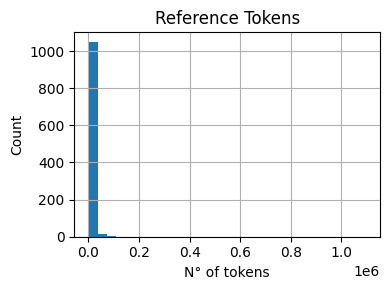

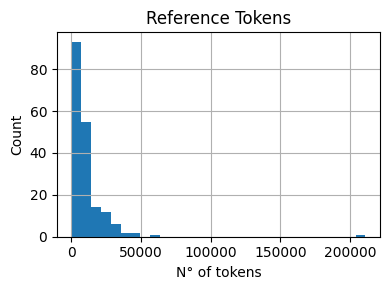

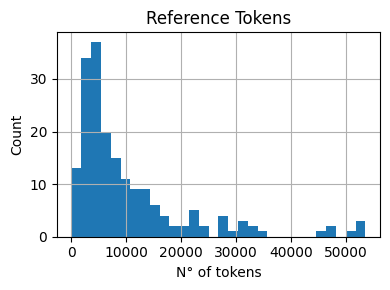

In [9]:
plt.figure(figsize=(4, 3))
plt.hist(new_train_df["reference_tokens"], label="Reference Tokens", bins=30)
plt.title("Reference Tokens")
plt.ylabel("Count")
plt.xlabel("N° of tokens")
plt.grid(True)
plt.tight_layout()
plt.savefig("reftokens_train.jpg")
plt.show()

plt.figure(figsize=(4, 3))
plt.hist(new_validation_df["reference_tokens"], label="Reference Tokens", bins=30)
plt.title("Reference Tokens")
plt.ylabel("Count")
plt.xlabel("N° of tokens")
plt.grid(True)
plt.tight_layout()
plt.savefig("reftokens_validation.jpg")
plt.show()

plt.figure(figsize=(4, 3))
plt.hist(new_test_df["reference_tokens"], label="Reference Tokens", bins=30)
plt.title("Reference Tokens")
plt.ylabel("Count")
plt.xlabel("N° of tokens")
plt.grid(True)
plt.tight_layout()
plt.savefig("reftokens_test.jpg")
plt.show()

In [10]:
# Some examples of the preprocessing

for index, _ in new_train_df[:3].iterrows():
    print(_["reference"][:1000], _["celex_id"])
    print("---------")

ha adopted this regulation : chapter i definition article 1 definition for the purpose of this regulation , the following definition shall apply : ( a ) ‘ asset-backed security ’ mean non-equity security which either : ( i ) represent an interest in asset , including any right intended to ensure the servicing of those asset , the receipt or the timely receipt by holder of those asset of the amount payable under those asset ; ( ii ) are secured by asset and the term of the security provide for payment calculated by reference to those asset ; ( b ) ‘ equivalent third country market ’ mean a third country market which ha been deemed equivalent to a regulated market in accordance with the requirement set out in third and fourth subparagraphs of article 25 ( 4 ) of directive 2014/65/eu of the european parliament and of the council ( 3 ) ; ( c ) ‘ profit estimate ’ mean a profit forecast for a financial period which ha expired and for which result have not yet been published ; ( d ) ‘ profit